# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline


'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

## get a feeling for the azdias data
# get shape of data frame
azdias.shape

(891221, 85)

In [4]:
# get information about the column and numer of entries
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [5]:
# get a first statistical overview of the azdias data
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
# print first 2 entries in the dataset of the azdias data
azdias.head(2)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0


In [7]:
## get a feeling for the feat_info data
# get shape of data frame
feat_info.shape

(85, 4)

In [8]:
# get information about the column and numer of entries
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [9]:
# get a first statistical overview of  he feat_info data
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,SEMIO_KULT,person,ordinal,[-1]
freq,1,43,49,26


In [10]:
# print first 2 entries in the dataset of the feat_info data
feat_info.head(2)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [11]:
## Identify missing or unknown data values and convert them to NaNs.

In [12]:
# before working on the data, create a copy of the data frames
azdias_clean = azdias.copy()
feat_info_clean = feat_info.copy()

In [13]:
# identify missing data at the beginning
nof_natural_missing_data = azdias_clean.isnull().sum().sum()
print('Number of naturally missing data: {}'.format(nof_natural_missing_data))

Number of naturally missing data: 4896838


In [14]:
# get information what are the unique encodings in the feat_info data frame
np.unique(feat_info.missing_or_unknown.values)

array(['[-1,0,9]', '[-1,0]', '[-1,9]', '[-1,XX]', '[-1,X]', '[-1]', '[0]',
       '[XX]', '[]'], dtype=object)

All existing error encodings are saved in lists and identified <br>
as int values: -1, 0, 1, 9 <br>
as str values: X, XX <br>

In [15]:
# get all attributes or column names
column_names = feat_info_clean['attribute'].values
# create a list containing all unique int values (see one cell above)
int_values = ['-1', '0', '1', '9']

# loop through all attributes
for col in range(len(column_names)):
    # get encoding_error values for current attribute
    encoding_error = feat_info_clean.loc[[col]].missing_or_unknown.values
    # remove list brackets per entry and separate the individual values
    for ii in range(len(encoding_error)):
        encoding_error[ii] = encoding_error[ii].strip('[').strip(']').split(',')    
    # check if any of the entries is an int value with the type str and change type if it is an int(see int_values list above)
    for jj in range(len(encoding_error[0])):
        if encoding_error[0][jj] in int_values:
            encoding_error[0][jj] = int(encoding_error[0][jj])
    
    # replace values in data frame azdias with nan which are encoded as error in the feat_info data frame
    azdias_clean[column_names[col]] = azdias_clean[column_names[col]].replace(encoding_error[0], np.nan)

In [16]:
# identify missing data after the mapping of the errors identified using the feat_info data frame
nof_missing_data_after_mapping = azdias_clean.isnull().sum()

print('The total number of missing data after mapping is: {}, which is an increase of: {}'.format(nof_missing_data_after_mapping.sum(), nof_missing_data_after_mapping.sum() - nof_natural_missing_data))

The total number of missing data after mapping is: 8373929, which is an increase of: 3477091


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [17]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# calculate ratio of missing data per attribute in descending order
missing_values_per_attribute = (nof_missing_data_after_mapping / azdias_clean.shape[0]).sort_values(ascending=False)
# show values
missing_values_per_attribute

TITEL_KZ                 0.997576
AGER_TYP                 0.769554
KK_KUNDENTYP             0.655967
KBA05_BAUMAX             0.534687
GEBURTSJAHR              0.440203
ALTER_HH                 0.348137
REGIOTYP                 0.177357
KKK                      0.177357
W_KEIT_KIND_HH           0.166051
KBA05_ANTG4              0.149597
KBA05_GBZ                0.149597
MOBI_REGIO               0.149597
KBA05_ANTG1              0.149597
KBA05_ANTG2              0.149597
KBA05_ANTG3              0.149597
PLZ8_GBZ                 0.130736
PLZ8_HHZ                 0.130736
PLZ8_BAUMAX              0.130736
PLZ8_ANTG4               0.130736
PLZ8_ANTG1               0.130736
PLZ8_ANTG3               0.130736
PLZ8_ANTG2               0.130736
SHOPPER_TYP              0.124768
VERS_TYP                 0.124768
HEALTH_TYP               0.124768
NATIONALITAET_KZ         0.121536
PRAEGENDE_JUGENDJAHRE    0.121366
KBA13_ANZAHL_PKW         0.118714
ANZ_HAUSHALTE_AKTIV      0.111769
CAMEO_INTL_201

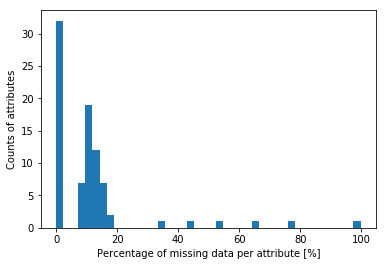

In [18]:
# Investigate patterns in the amount of missing data in each column.

plt.hist(missing_values_per_attribute*100, bins=42);
plt.xlabel('Percentage of missing data per attribute [%]');
plt.ylabel('Counts of attributes');

In [19]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# I define an attribute as an outlier if more than 20% of the rows have missing values
threshold_outlier = 0.2

In [20]:
# get attribute outlier
columns_outlier = missing_values_per_attribute[missing_values_per_attribute>threshold_outlier]
columns_outlier

TITEL_KZ        0.997576
AGER_TYP        0.769554
KK_KUNDENTYP    0.655967
KBA05_BAUMAX    0.534687
GEBURTSJAHR     0.440203
ALTER_HH        0.348137
dtype: float64

In [21]:
# drop outlier columns in data frame azdias
azdias_clean.drop(columns_outlier.index, axis=1, inplace=True)

In [22]:
feat_info_clean

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [23]:
# drop outlier columns in data frame feat_info
for col_outlier in columns_outlier.index:
    feat_info_clean = feat_info_clean[feat_info_clean.attribute != col_outlier]

In [24]:
# check number of rows & columns
print(azdias_clean.shape)
print(feat_info_clean.shape)

(891221, 79)
(79, 4)


#### Discussion 1.1.2: Assess Missing Data in Each Column

From the histogram above it is clearly visible that the most attributes have less than 20% of missing data. The distribution of missing data is around approximately 10% and 18% and therefore enables me to clearly separate the outliers using a threshold of 20% missing data. <br>
The removed columns are saved in the columns_outlier variable and contains the following 6 attributes: TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, ALTER_HH

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

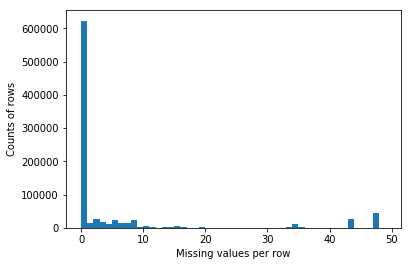

In [25]:
# How much data is missing in each row of the dataset?

# calculate the number of missing data per row in descending order
missing_values_per_row = azdias_clean.isnull().sum(axis=1).sort_values(ascending=False)
# show histogram plot of missing values per row
plt.hist(missing_values_per_row, bins=max(missing_values_per_row));
plt.xlabel('Missing values per row');
plt.ylabel('Counts of rows');


In [26]:
print('Percentage of rows with less than 10 missing values: {}'.format((missing_values_per_row < 10).sum() / azdias_clean.shape[0]))

Percentage of rows with less than 10 missing values: 0.8693051442908101


From the above histogram and the last calculation one sees that setting a threshold to 10 missing values per row will divide the data into two subsets in which one has more than 85% of all rows with just a few missing values (less than 10) and one has less than 15% of the rows with a number of missing values of more or equal to 10 missing values.

In [27]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# define the threshold for the number of missing data to 10
threshold_missing_values_per_row = 10
# get the two data subsets
missing_values_per_row_above_thres = azdias_clean[missing_values_per_row > threshold_missing_values_per_row]
missing_values_per_row_below_thres = azdias_clean[missing_values_per_row <= threshold_missing_values_per_row]
# print results
print('Number of rows with more missing values than the threshold: {}'.format(missing_values_per_row_above_thres.shape[0]))
print('Number of rows with less missing values than the threshold: {}'.format(missing_values_per_row_below_thres.shape[0]))


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Number of rows with more missing values than the threshold: 111068
Number of rows with less missing values than the threshold: 780153


In [28]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# get columns with no missing values
columns_no_missing_values = missing_values_per_attribute[missing_values_per_attribute==0].index
# get 5 columns with no missing values by using numpy random choice
columns_no_missing_values_sample = np.random.choice(columns_no_missing_values, 5, replace=False)
columns_no_missing_values_sample

array(['SEMIO_VERT', 'SEMIO_TRADV', 'SEMIO_SOZ', 'SEMIO_KRIT', 'SEMIO_REL'], dtype=object)

In [29]:
# define a function to plot the counts for both subsets
def plot_compare_rows(column_name):
    fig = plt.figure(20, figsize=(14,4))
    base_color = sns.color_palette()[0] # use same color for all bars
    
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('Row with LESS than {} missing values'.format(threshold_missing_values_per_row))
    sns.countplot(missing_values_per_row_below_thres[column_name], color = base_color)
    
    ax2 = fig.add_subplot(122)
    ax2.title.set_text('Row with MORE than {} missing values'.format(threshold_missing_values_per_row))
    sns.countplot(missing_values_per_row_above_thres[column_name], color = base_color)
                                                       
    fig.suptitle(column_name)
    plt.show()

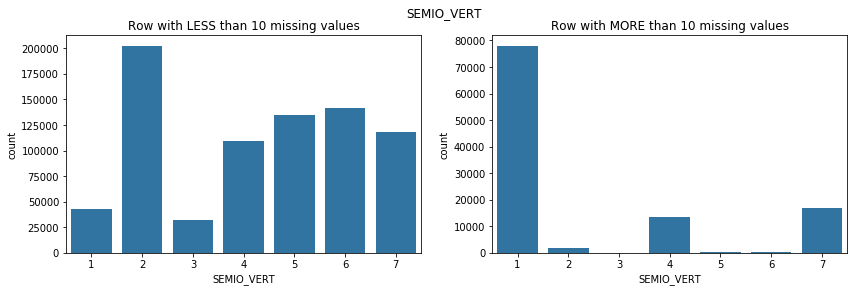

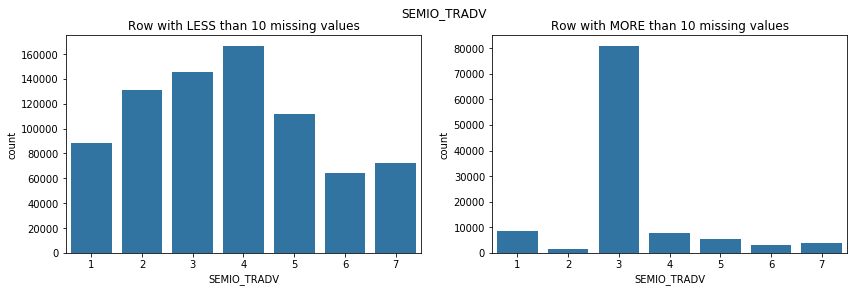

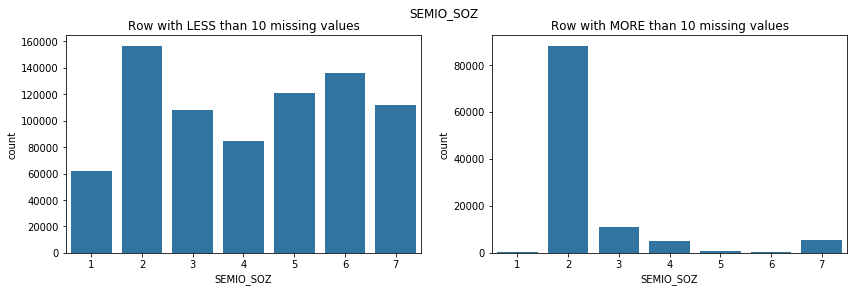

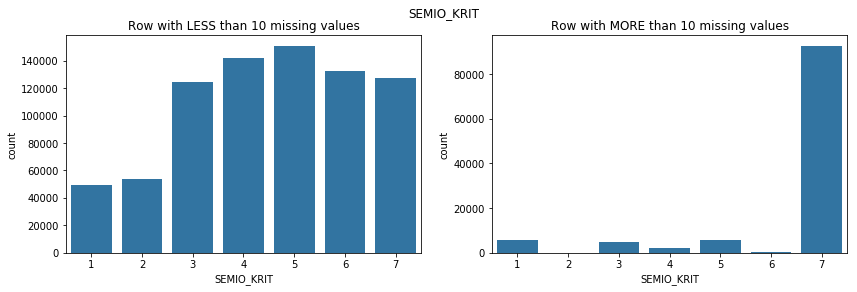

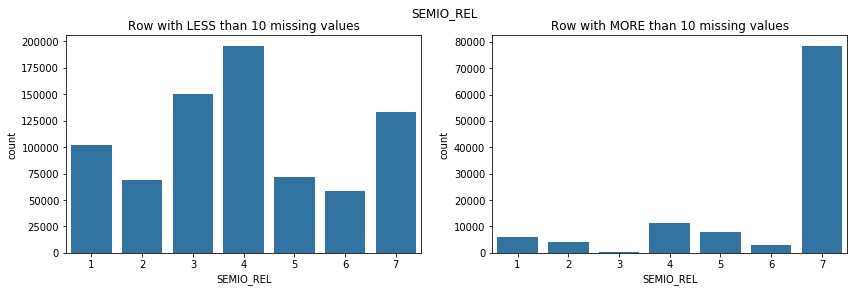

In [30]:
for col in columns_no_missing_values_sample:
    plot_compare_rows(col)

In [31]:
# Fill missing values with most frequent value for further analysis
missing_values_per_row_below_thres = missing_values_per_row_below_thres.fillna(missing_values_per_row_below_thres.mode().iloc[0])

#### Discussion 1.1.3: Assess Missing Data in Each Row

From  above, one sees that setting a threshold to 10 missing values per row will divide the data into two subsets in which one has more than 85% of all rows with just a few missing values (less than 10) and one has less than 15% of the rows with more missing values. <br>
Creating countplots of the five randomly picked columns, the plots show a different behaviour for the two subsets. Therefore the subset with more than 10 missing values can be marked as special and the two subsets could be used for further investigations. <br>
The NaN values of the subset with less than 10 missing values will be replaced with the most frequent value of each feature for further analysis. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [32]:
# How many features are there of each data type?
nof_features_per_type = feat_info_clean.type.value_counts()
nof_features_per_type

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [33]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# get categorical features
cat_features = feat_info_clean[feat_info_clean.type == 'categorical']
cat_features

,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [34]:
## separate categorical features into binary and multi_level_features

# allocate list variables
binary_feature = []
multi_level_feature=[]

# check all features if they have two (binary) or more unique values
for tmp_feature in cat_features.attribute:
    if (len(missing_values_per_row_below_thres[tmp_feature].unique())==2):
        binary_feature.append(tmp_feature)
    elif (len(missing_values_per_row_below_thres[tmp_feature].unique())>2):
        multi_level_feature.append(tmp_feature)

In [35]:
# get unique values for binary features
for tmp_feature in binary_feature:
    print('Binary feature {} has the unique values: {}'.format(tmp_feature, missing_values_per_row_below_thres[tmp_feature].unique()))

Binary feature ANREDE_KZ has the unique values: [2 1]
Binary feature GREEN_AVANTGARDE has the unique values: [0 1]
Binary feature SOHO_KZ has the unique values: [ 1.  0.]
Binary feature VERS_TYP has the unique values: [ 2.  1.]
Binary feature OST_WEST_KZ has the unique values: ['W' 'O']


From the five binary features has OST_WEST_KZ non integer values ('W' and 'O') which will be replaced by (1 for 'W' and 0 for 'O'). 

In [36]:
## Re-encode categorical variable(s) to be kept in the analysis.

# replace unique values for column OST_WEST_KZ  to integer values (1 for 'W' and 0 for 'O')
# code example from pandas replace documentation has been used, see reference [R1] for a link: 
missing_values_per_row_below_thres.OST_WEST_KZ = missing_values_per_row_below_thres.OST_WEST_KZ.replace({'O': 0, 'W': 1});

In [37]:
# check if values of column OST_WEST_KZ are now integer
missing_values_per_row_below_thres.OST_WEST_KZ.unique()

array([1, 0])

For the remaining multi level features I will create dummy variables via one-hot-encoder to use them later on.

In [38]:
## multi level features

# create dummy variables for the remaining multi level features and saved it in the new data frame azdias_clean_less_missing
azdias_clean_less_missing = pd.get_dummies(missing_values_per_row_below_thres, columns=multi_level_feature)

In [39]:
# get size of new data frame
azdias_clean_less_missing.shape

(780153, 194)

#### Discussion 1.2.1: Re-Encode Categorical Features

In the data frame were 18 categorical features left. <br>

Six of them are binary features which column names are saved in the list binary_feature. The values of the binary feature _OST_WEST_KZ_ had to be re-encoded, because it contained strings as unique values. The values were replaced by 1 for 'W' and 0 for 'O'. The other binary features have not been changed. <br>

I created dummy variables via one-hot-encoder for the remaining multi level features to be able to use them later on. The new data frame has now 194 columns. <br>


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [40]:
## Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# 2 new columns will be created: 
# "PRAEGENDE_JUGENDJAHRE_MA" for the movement in the first step and 
# "PRAEGENDE_JUGENDJAHRE_DEC" for the decade. 
# The old column "PRAEGENDE_JUGENDJAHRE" will be drop at the end. 

# Encoding due to Data_Dictionary.md:
#-  1: 40s - war years (Mainstream, E+W)
#-  2: 40s - reconstruction years (Avantgarde, E+W)
#-  3: 50s - economic miracle (Mainstream, E+W)
#-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
#-  5: 60s - economic miracle (Mainstream, E+W)
#-  6: 60s - generation 68 / student protestors (Avantgarde, W)
#-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
#-  8: 70s - family orientation (Mainstream, E+W)
#-  9: 70s - peace movement (Avantgarde, E+W)
#- 10: 80s - Generation Golf (Mainstream, W)
#- 11: 80s - ecological awareness (Avantgarde, W)
#- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
#- 13: 80s - Swords into ploughshares (Avantgarde, E)
#- 14: 90s - digital media kids (Mainstream, E+W)
#- 15: 90s - ecological awareness (Avantgarde, E+W)


In [41]:
## create dictionaries for the encoding

# Movement will be encoded by a binary variable using 0 for mainstream and 1 for avantgarde
dict_MA = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
# Decade will be encoded using the decade
dict_DEC = {1:1940, 2:1940, 3:1950, 4:1951, 5:1960, 6:1960, 7:1960, 8:1970, 9:1970, 10:1980, 11:1980, 12:1980, 13:1980, 14:1990, 15:1991}

In [42]:
## Investigate "PRAEGENDE_JUGENDJAHRE_MA" using the abbreviation MA for Mainstream and Avantgarde

# create new column "PRAEGENDE_JUGENDJAHRE_MA"
azdias_clean_less_missing['PRAEGENDE_JUGENDJAHRE_MA'] = azdias_clean_less_missing['PRAEGENDE_JUGENDJAHRE']
# encode by a binary variable using 0 for mainstream and 1 for avantgarde using dict_MA
azdias_clean_less_missing['PRAEGENDE_JUGENDJAHRE_MA'] = azdias_clean_less_missing['PRAEGENDE_JUGENDJAHRE_MA'].replace(dict_MA)
# test new column
azdias_clean_less_missing['PRAEGENDE_JUGENDJAHRE_MA'].value_counts()

0.0    608462
1.0    171691
Name: PRAEGENDE_JUGENDJAHRE_MA, dtype: int64

In [43]:
## Investigate "PRAEGENDE_JUGENDJAHRE_DEC" using the abbreviation DEC for DECade

# create new column "PRAEGENDE_JUGENDJAHRE_DEC"
azdias_clean_less_missing['PRAEGENDE_JUGENDJAHRE_DEC'] = azdias_clean_less_missing['PRAEGENDE_JUGENDJAHRE']
# encode by a multi level variable using the decade encoding of dictionary dict_DEC
azdias_clean_less_missing['PRAEGENDE_JUGENDJAHRE_DEC'] = azdias_clean_less_missing['PRAEGENDE_JUGENDJAHRE_DEC'].replace(dict_DEC)
# test new column
azdias_clean_less_missing['PRAEGENDE_JUGENDJAHRE_DEC'].value_counts()

1990.0    204884
1970.0    171875
1980.0    148118
1960.0    113126
1950.0     53098
1991.0     41029
1940.0     27680
1951.0     20343
Name: PRAEGENDE_JUGENDJAHRE_DEC, dtype: int64

In [44]:
# drop column "PRAEGENDE_JUGENDJAHRE"
azdias_clean_less_missing.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [45]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# 2 new columns will be created: 
# "CAMEO_INTL_2015_WEALTH" for the wealth in the first step and 
# "CAMEO_INTL_2015_LIFE_STAGE" for the life stage. 
# The old column "CAMEO_INTL_2015" will be drop at the end. 

# Encoding due to Data_Dictionary.md:
#German CAMEO: Wealth / Life Stage Typology, mapped to international code
#- 11: Wealthy Households - Pre-Family Couples & Singles
#- 12: Wealthy Households - Young Couples With Children
#- 13: Wealthy Households - Families With School Age Children
#- 14: Wealthy Households - Older Families &  Mature Couples
#- 15: Wealthy Households - Elders In Retirement
#- 21: Prosperous Households - Pre-Family Couples & Singles
#- 22: Prosperous Households - Young Couples With Children
#- 23: Prosperous Households - Families With School Age Children
#- 24: Prosperous Households - Older Families & Mature Couples
#- 25: Prosperous Households - Elders In Retirement
#- 31: Comfortable Households - Pre-Family Couples & Singles
#- 32: Comfortable Households - Young Couples With Children
#- 33: Comfortable Households - Families With School Age Children
#- 34: Comfortable Households - Older Families & Mature Couples
#- 35: Comfortable Households - Elders In Retirement
#- 41: Less Affluent Households - Pre-Family Couples & Singles
#- 42: Less Affluent Households - Young Couples With Children
#- 43: Less Affluent Households - Families With School Age Children
#- 44: Less Affluent Households - Older Families & Mature Couples
#- 45: Less Affluent Households - Elders In Retirement
#- 51: Poorer Households - Pre-Family Couples & Singles
#- 52: Poorer Households - Young Couples With Children
#- 53: Poorer Households - Families With School Age Children
#- 54: Poorer Households - Older Families & Mature Couples
#- 55: Poorer Households - Elders In Retirement


In [46]:
## create dictionaries for the encoding

# Wealth will be encoded using
# 1 - Wealthy Households
# 2 - Prosperous Households
# 3 - Comfortable Households
# 4 - Less Affluent Households
# 5 - Poorer Households
dict_WEALTH = {11:1, 12:1, 13:1, 14:1, 15:1,
               21:2, 22:2, 23:2, 24:2, 25:2,
               31:3, 32:3, 33:3, 34:3, 35:3,
               41:4, 42:4, 43:4, 44:4, 45:4,
               51:5, 52:5, 53:5, 54:5, 55:5}

# Life stage will be encoded using
# 1 - Pre-Family Couples & Singles
# 2 - Young Couples With Children
# 3 - Families With School Age Children
# 4 - Older Families & Mature Couples
# 5 - Elders In Retirement
dict_LIFE_STAGE = {11:1, 21:1, 31:1, 41:1, 51:1,
                   12:2, 22:2, 32:2, 42:2, 52:2,
                   13:3, 23:3, 33:3, 43:3, 53:3,
                   14:4, 24:4, 34:4, 44:4, 54:4,
                   15:5, 25:5, 35:5, 45:5, 55:5}

In [47]:
azdias_clean_less_missing['CAMEO_INTL_2015'].unique()

array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', '25', '23', '31', '52', '35', '45', '44', '32'], dtype=object)

In [48]:
## Investigate "CAMEO_INTL_2015_WEALTH"

# create new column "CAMEO_INTL_2015_WEALTH"
azdias_clean_less_missing['CAMEO_INTL_2015_WEALTH'] = azdias_clean_less_missing['CAMEO_INTL_2015']
# change type to int (code inspiration from [R2])
azdias_clean_less_missing["CAMEO_INTL_2015_WEALTH"] = pd.to_numeric(azdias_clean_less_missing["CAMEO_INTL_2015_WEALTH"])
# encode CAMEO_INTL_2015_WEALTH column using dict_WEALTH
azdias_clean_less_missing['CAMEO_INTL_2015_WEALTH'] = azdias_clean_less_missing['CAMEO_INTL_2015_WEALTH'].replace(dict_WEALTH)
# test new column
azdias_clean_less_missing['CAMEO_INTL_2015_WEALTH'].value_counts()

5    225510
4    187271
2    184575
1    116706
3     66091
Name: CAMEO_INTL_2015_WEALTH, dtype: int64

In [49]:
## Investigate "CAMEO_INTL_2015_LIFE_STAGE"

# create new column "CAMEO_INTL_2015_LIFE_STAGE"
azdias_clean_less_missing['CAMEO_INTL_2015_LIFE_STAGE'] = azdias_clean_less_missing['CAMEO_INTL_2015']
# change type to numeric (code inspiration from [R2])
azdias_clean_less_missing["CAMEO_INTL_2015_LIFE_STAGE"] = pd.to_numeric(azdias_clean_less_missing["CAMEO_INTL_2015_LIFE_STAGE"])
# encode CAMEO_INTL_2015_LIFE_STAGE column using dict_LIFE_STAGE
azdias_clean_less_missing['CAMEO_INTL_2015_LIFE_STAGE'] = azdias_clean_less_missing['CAMEO_INTL_2015_LIFE_STAGE'].replace(dict_LIFE_STAGE)
# test new column
azdias_clean_less_missing['CAMEO_INTL_2015_LIFE_STAGE'].value_counts()

1    245433
4    228456
3    115411
5    115187
2     75666
Name: CAMEO_INTL_2015_LIFE_STAGE, dtype: int64

In [50]:
# drop column "CAMEO_INTL_2015"
azdias_clean_less_missing.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [51]:
# get mixed features
mixed_features = feat_info_clean[feat_info_clean.type == 'mixed']
mixed_features

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


There are six mixed attributes. "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015" are already new encoded. <br>
The attributes "LP_LEBENSPHASE_FEIN" and "LP_LEBENSPHASE_GROB" are be droped, because they are already covered by "CAMEO_INTL_2015" or now by the two new attributes "CAMEO_INTL_2015_WEALTH" and "CAMEO_INTL_2015_LIFE_STAGE". <br>
"WOHNLAGE" and "PLZ8_BAUMAX" are describing similar information therefore I will drop "PLZ8_BAUMAX" and keep "WOHNLAGE".

In [52]:
# drop attributes "LP_LEBENSPHASE_FEIN", "LP_LEBENSPHASE_GROB" and "PLZ8_BAUMAX"
azdias_clean_less_missing.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)
azdias_clean_less_missing.drop('LP_LEBENSPHASE_GROB', axis=1, inplace=True)
azdias_clean_less_missing.drop('PLZ8_BAUMAX', axis=1, inplace=True)

In [53]:
azdias_clean_less_missing['WOHNLAGE'].value_counts()

3.0    246155
7.0    167130
4.0    134022
2.0     98784
5.0     72899
1.0     43191
8.0     15018
0.0      2954
Name: WOHNLAGE, dtype: int64

The encoding of "WOHNLAGE" is already fine and needs no further modification steps. Due to the feat_info data frame the entry 0 is not resenting missing data. The score is just not calculated.

#### Discussion 1.2.2: Engineer Mixed-Type Features

There are six mixed attributes: "LP_LEBENSPHASE_FEIN", "LP_LEBENSPHASE_GROB", "PRAEGENDE_JUGENDJAHRE", "WOHNLAGE", "CAMEO_INTL_2015", "PLZ8_BAUMAX" <br>

The attributes "LP_LEBENSPHASE_FEIN" and "LP_LEBENSPHASE_GROB" are be droped, because they are already covered by "CAMEO_INTL_2015". <br>
The attribute "CAMEO_INTL_2015" is re-encoded into the two new atomic attributes "CAMEO_INTL_2015_WEALTH" and "CAMEO_INTL_2015_LIFE_STAGE". <br>
"PRAEGENDE_JUGENDJAHRE" is also re-encoded into the two new atomic attributes "PRAEGENDE_JUGENDJAHRE_MA" and "PRAEGENDE_JUGENDJAHRE_DEC". <br>
"WOHNLAGE" and "PLZ8_BAUMAX" are describing similar information therefore I will drop "PLZ8_BAUMAX" and keep "WOHNLAGE" which encoding is already fine and needs no further modification steps. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [54]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)


In [55]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.


In [56]:
# get info of data frame to check if all types are numeric
azdias_clean_less_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780153 entries, 1 to 891220
Columns: 193 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_LIFE_STAGE
dtypes: float64(40), int64(25), uint8(128)
memory usage: 488.1 MB


All steps have been performed in the previous sections. The above cell shows in addition that all column types are numeric (40x float, 25x int64, 128x uint8) which can be used for further analysis.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [57]:
def convert_missing_data_to_nan(df, feat_info):
    # get all attributes or column names
    column_names = feat_info['attribute'].values
    # create a list containing all unique int values (see one cell above)
    int_values = ['-1', '0', '1', '9']

    # loop through all attributes
    for col in range(len(column_names)):
        # get encoding_error values for current attribute
        encoding_error = feat_info.loc[[col]].missing_or_unknown.values
        # remove list brackets per entry and separate the individual values
        for ii in range(len(encoding_error)):
            encoding_error[ii] = encoding_error[ii].strip('[').strip(']').split(',')    
        # check if any of the entries is an int value with the type str and change type if it is an int(see int_values list above)
        for jj in range(len(encoding_error[0])):
            if encoding_error[0][jj] in int_values:
                encoding_error[0][jj] = int(encoding_error[0][jj])
    
        # replace values in data frame azdias with nan which are encoded as error in the feat_info data frame
        df[column_names[col]] = df[column_names[col]].replace(encoding_error[0], np.nan)

    # return cleaned data frame
    return df

In [58]:
def remove_noisy_columns(df, feat_info, thresh_perc_col, columns_outlier=''):
    # calculate ratio of missing data per attribute in descending order
    missing_values_per_attribute = (df.isnull().sum() / df.shape[0]).sort_values(ascending=False)
    # get attribute outlier
    if (len(columns_outlier) == 0): # if no columns_outlier list as argument given, use given threshold
        columns_outlier = missing_values_per_attribute[missing_values_per_attribute>thresh_perc_col]
    # drop outlier columns in data frame azdias
    df.drop(columns_outlier.index, axis=1, inplace=True)
    # drop outlier columns in data frame feat_info
    for col_outlier in columns_outlier.index:
        feat_info = feat_info[feat_info.attribute != col_outlier]
    # return clean data frame
    return df, feat_info, columns_outlier

In [59]:
def remove_noisy_rows(df, thresh_abs_row, columns_outlier=''):
    # calculate the number of missing data per row in descending order
    missing_values_per_row = df.isnull().sum(axis=1).sort_values(ascending=False)
    # fill just be used if the dataset is not the customer one
    if (len(columns_outlier) == 0): # if no columns_outlier list as argument given, use given threshold
        df = df[missing_values_per_row <= thresh_abs_row] # remove rows with more missing values than threshold
    # Fill missing values with most frequent value for further analysis
    #df = df.fillna(df.mode().iloc[0])
    # return clean data frame
    return df

In [60]:
def encode_cat_attributes(df, feat_info):
    ## get categorical features
    cat_features = feat_info[feat_info.type == 'categorical']
    
    ## separate categorical features into binary and multi_level_features
    # allocate list variables
    binary_feature = []
    multi_level_feature=[]
    # check all features if they have two (binary) or more unique values
    for tmp_feature in cat_features.attribute:
        if (pd.notna(df[tmp_feature].unique()).sum()==2):
            binary_feature.append(tmp_feature)
        elif (len(df[tmp_feature].unique())>2):
            multi_level_feature.append(tmp_feature)

    ## Re-encode categorical variable(s) to be kept in the analysis.
    # replace unique values for column OST_WEST_KZ  to integer values (1 for 'W' and 0 for 'O')
    # code example from pandas replace documentation has been used, see reference [R1] for a link: 
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'O': 0, 'W': 1});

    ## multi level features
    # create dummy variables for the remaining multi level features and saved it in the new data frame azdias_clean_less_missing
    df_clean = pd.get_dummies(df, columns=multi_level_feature)
    
    ## return cleaned data frame
    return df_clean

In [61]:
def encode_mixed_attributes(df):
    #Encode "PRAEGENDE_JUGENDJAHRE"  and engineer two new variables "PRAEGENDE_JUGENDJAHRE_MA" and "PRAEGENDE_JUGENDJAHRE_DEC"
    # Movement will be encoded by a binary variable using 0 for mainstream and 1 for avantgarde
    dict_MA = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
    # Decade will be encoded using the decade
    dict_DEC = {1:1940, 2:1940, 3:1950, 4:1951, 5:1960, 6:1960, 7:1960, 8:1970, 9:1970, 10:1980, 11:1980, 12:1980, 13:1980, 14:1990, 15:1991}
    # create new column "PRAEGENDE_JUGENDJAHRE_MA"
    df['PRAEGENDE_JUGENDJAHRE_MA'] = df['PRAEGENDE_JUGENDJAHRE']
    # encode by a binary variable using 0 for mainstream and 1 for avantgarde using dict_MA
    df['PRAEGENDE_JUGENDJAHRE_MA'] = df['PRAEGENDE_JUGENDJAHRE_MA'].replace(dict_MA)    
    # create new column "PRAEGENDE_JUGENDJAHRE_DEC"
    df['PRAEGENDE_JUGENDJAHRE_DEC'] = df['PRAEGENDE_JUGENDJAHRE']
    # encode by a multi level variable using the decade encoding of dictionary dict_DEC
    df['PRAEGENDE_JUGENDJAHRE_DEC'] = df['PRAEGENDE_JUGENDJAHRE_DEC'].replace(dict_DEC)
    # drop column "PRAEGENDE_JUGENDJAHRE"
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

    #Encode "CAMEO_INTL_2015" and engineer two new variables "CAMEO_INTL_2015_WEALTH" and "CAMEO_INTL_2015_LIFE_STAGE"
    # Wealth will be encoded using
    # 1 - Wealthy Households
    # 2 - Prosperous Households
    # 3 - Comfortable Households
    # 4 - Less Affluent Households
    # 5 - Poorer Households
    dict_WEALTH = {11:1, 12:1, 13:1, 14:1, 15:1,
                   21:2, 22:2, 23:2, 24:2, 25:2,
                   31:3, 32:3, 33:3, 34:3, 35:3,
                   41:4, 42:4, 43:4, 44:4, 45:4,
                   51:5, 52:5, 53:5, 54:5, 55:5}
    # Life stage will be encoded using
    # 1 - Pre-Family Couples & Singles
    # 2 - Young Couples With Children
    # 3 - Families With School Age Children
    # 4 - Older Families & Mature Couples
    # 5 - Elders In Retirement
    dict_LIFE_STAGE = {11:1, 21:1, 31:1, 41:1, 51:1,
                       12:2, 22:2, 32:2, 42:2, 52:2,
                       13:3, 23:3, 33:3, 43:3, 53:3,
                       14:4, 24:4, 34:4, 44:4, 54:4,
                       15:5, 25:5, 35:5, 45:5, 55:5}
    # create new column "CAMEO_INTL_2015_WEALTH"
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015']
    # change type to int (code inspiration from [R2])
    df["CAMEO_INTL_2015_WEALTH"] = pd.to_numeric(df["CAMEO_INTL_2015_WEALTH"])
    # encode CAMEO_INTL_2015_WEALTH column using dict_WEALTH
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015_WEALTH'].replace(dict_WEALTH)
    # create new column "CAMEO_INTL_2015_LIFE_STAGE"
    df['CAMEO_INTL_2015_LIFE_STAGE'] = df['CAMEO_INTL_2015']
    # change type to numeric (code inspiration from [R2])
    df["CAMEO_INTL_2015_LIFE_STAGE"] = pd.to_numeric(df["CAMEO_INTL_2015_LIFE_STAGE"])
    # encode CAMEO_INTL_2015_LIFE_STAGE column using dict_LIFE_STAGE
    df['CAMEO_INTL_2015_LIFE_STAGE'] = df['CAMEO_INTL_2015_LIFE_STAGE'].replace(dict_LIFE_STAGE)
    # drop column "CAMEO_INTL_2015"
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)

    # drop attributes "LP_LEBENSPHASE_FEIN", "LP_LEBENSPHASE_GROB" and "PLZ8_BAUMAX"
    df.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)
    df.drop('LP_LEBENSPHASE_GROB', axis=1, inplace=True)
    df.drop('PLZ8_BAUMAX', axis=1, inplace=True)
    
    # return cleaned data frame
    return df

In [62]:
def clean_data(df, feat_info, thresh_perc_col=0.2, thresh_abs_row=20, columns_outlier=''):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT:  Demographics DataFrame,
            Feature Summary DataFrame,
            Threshold for allowed missing values per attribute [between 0 and 1]
            Threshold for allowed missing values per row [absolute values]
            Columns_outlier indicates if the outliers are already known. This is the case if the function is used with the customer dataset
            
    OUTPUT: Trimmed and cleaned demographics DataFrame
            Trimmed and cleaned feat_info DataFrame
            List containing the columns_outlier
    """
    
    # Put in code here to execute all main cleaning steps:
    ## Step 1: convert missing value codes into NaNs, ...
    df_clean = convert_missing_data_to_nan(df, feat_info)
    
    ## Step 2: remove selected columns and rows, ...
    # clean columns
    df_clean, feat_info_clean, columns_outlier = remove_noisy_columns(df_clean, feat_info, thresh_perc_col, columns_outlier)
    # clean rows
    df_clean = remove_noisy_rows(df_clean, thresh_abs_row, columns_outlier)
    
    ## Step 3: select, re-encode, and engineer column values.
    # encode categorical attributes
    df_clean = encode_cat_attributes(df_clean, feat_info_clean)
    # encode mixed attributes
    df_clean = encode_mixed_attributes(df_clean)
    
    ## Step 4:  Return the cleaned dataframe.
    return df_clean, feat_info_clean, columns_outlier
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [63]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# no missing data, because cleaning function will be replace missing values by most frequent one

# create copy of data frame
azdias_clean = azdias.copy()

# clean data frame using the above defined function
azdias_clean, feat_info_clean, columns_outlier_azdias = clean_data(azdias_clean, feat_info, 0.20, 10)

# print message "cleaning done"
print('Cleaning done for data frames "azdias" and "feat_info"')

Cleaning done for data frames "azdias" and "feat_info"


In [64]:
azdias_clean.shape

(891221, 193)

In [65]:
# use Imputer to fill NaN
fill_nan = Imputer(strategy='most_frequent')
azdias_clean = pd.DataFrame(fill_nan.fit_transform(azdias_clean), columns=list(azdias_clean))

In [66]:
print('Number of missing values in data frame azdias_clean: {}'.format(azdias_clean.isnull().sum().sum()))

Number of missing values in data frame azdias_clean: 0


In [67]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_clean_scaled = scaler.fit_transform(azdias_clean)

In [68]:
azdias_clean_scaled

array([[-0.75167967, -1.045218  , -0.05641562, ...,  0.98950296,
         1.03993811, -1.09586631],
       [-1.74333933,  0.95673821, -1.57035806, ...,  0.98950296,
         1.03993811, -1.09586631],
       [ 0.23997999,  0.95673821, -1.57035806, ...,  1.05738008,
        -0.98045299,  0.87958079],
       ..., 
       [-0.75167967,  0.95673821, -0.81338684, ...,  0.98950296,
        -0.98045299,  0.87958079],
       [-1.74333933, -1.045218  , -1.57035806, ...,  0.98950296,
         1.03993811, -1.09586631],
       [ 1.23163965, -1.045218  ,  0.7005556 , ..., -1.72558193,
         0.36647441,  0.22109842]])

In [69]:
# convert azdias_clean_scaled into data frame with the same column names as the unscaled 
azdias_clean_scaled = pd.DataFrame(azdias_clean_scaled, columns=list(azdias_clean), index=azdias_clean.index)
azdias_clean_scaled.head(3)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_MA,PRAEGENDE_JUGENDJAHRE_DEC,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,-0.751680,-1.045218,-0.056416,0.804890,-0.303378,1.285741,1.429871,-0.055511,-0.494701,0.938197,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,-0.494701,0.989503,1.039938,-1.095866
1,-1.743339,0.956738,-1.570358,1.487601,-1.059731,1.285741,0.757254,1.422415,-0.494701,0.938197,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,-0.494701,0.989503,1.039938,-1.095866
2,0.239980,0.956738,-1.570358,0.804890,-1.816084,-0.675554,0.084637,1.422415,2.021423,0.938197,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,2.021423,1.057380,-0.980453,0.879581


### Discussion 2.1: Apply Feature Scaling

There were no more missing values, because even if the threshold of the missing value per row is set to a number greater than 0, all missing values will be replaced by the most frequent one. For detail, please have a look at the function "remove_noisy_rows". All features have been scaled using the StandardScaler. For an easier view and further analysis, the scaled data have been saved again in a data frame. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [70]:
# Apply PCA to the data.
pca = PCA()
pca.fit(azdias_clean_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

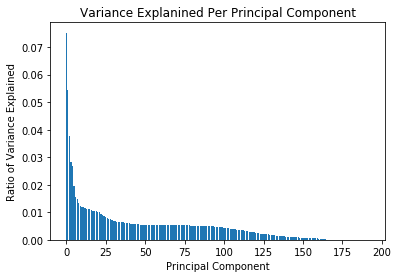

In [71]:
# Investigate the variance accounted for by each principal component.
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_);
plt.title('Variance Explanined Per Principal Component');
plt.xlabel('Principal Component');
plt.ylabel('Ratio of Variance Explained');


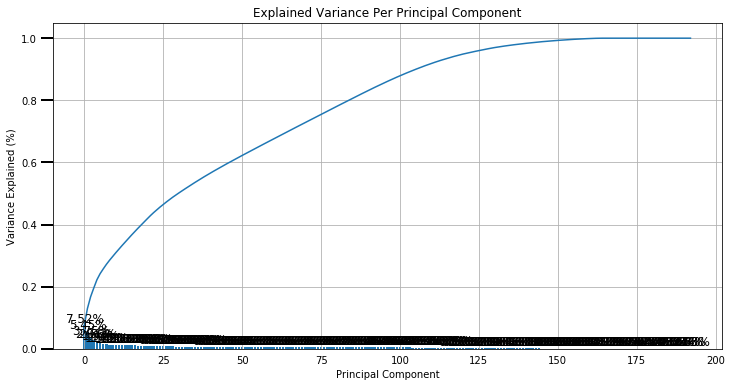

In [72]:
# Function definition from helper.py of Udacity ND Course, Section 4.4.14 [R3]
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    INPUT: pca - the result of instantian of PCA in scikit learn    
    OUTPUT: None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    plt.grid(True)
    
scree_plot(pca)

In [73]:
# calculate cumulative variance for 95 components
print('Number of components: {}'.format(len(pca.explained_variance_ratio_)))
print('Cumulative Variance for 95 components: {}'.format(pca.explained_variance_ratio_[:95].sum()))

Number of components: 193
Cumulative Variance for 95 components: 0.8513372112876733


In [74]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_95 = PCA(n_components=95)
azdias_pca = pca_95.fit_transform(azdias_clean_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

I used the plotting function which we already used within the Nanodegree course to plot the single and the cumulative variance. This plot shows that taking into account **95 components** will lead to a cumulative explained variance of around 85% while reducing the number of components by around 50% which also leads to a reduction in the computational time. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [75]:
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_weight(pca, i):
    # create data frame containing the components and use the names from the sclaed azdias data frame
    df = pd.DataFrame(pca.components_, columns=list(azdias_clean_scaled.columns))
    # get i-th value and sort values in descending order
    weight = df.iloc[i].sort_values(ascending=False)
    # return weight
    return weight

In [76]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_first = pca_weight(pca_95, 0)
pca_weight_first

CAMEO_INTL_2015_WEALTH        0.186869
PLZ8_ANTG3                    0.183610
LP_STATUS_GROB_1.0            0.180157
EWDICHTE                      0.159679
ORTSGR_KLS9                   0.150808
PLZ8_ANTG4                    0.148434
HH_EINKOMMEN_SCORE            0.142488
FINANZ_HAUSBAUER              0.139551
FINANZ_SPARER                 0.137703
PLZ8_ANTG2                    0.127002
ARBEIT                        0.121051
KBA05_ANTG4                   0.116594
LP_STATUS_FEIN_2.0            0.116055
FINANZTYP_1                   0.111799
LP_STATUS_FEIN_1.0            0.111493
RELAT_AB                      0.105144
CAMEO_DEUG_2015_9             0.104596
ANZ_HAUSHALTE_AKTIV           0.103478
KBA05_ANTG3                   0.103037
PRAEGENDE_JUGENDJAHRE_DEC     0.102972
SEMIO_REL                     0.102943
SEMIO_PFLICHT                 0.102146
FINANZ_ANLEGER                0.084934
FINANZ_UNAUFFAELLIGER         0.084129
SEMIO_RAT                     0.083471
CAMEO_DEUG_2015_8        

In [77]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_second = pca_weight(pca_95, 1)
pca_weight_second

ALTERSKATEGORIE_GROB         0.221012
FINANZ_VORSORGER             0.212701
SEMIO_ERL                    0.172550
RETOURTYP_BK_S               0.156384
ZABEOTYP_3                   0.150864
SEMIO_LUST                   0.146763
LP_STATUS_FEIN_1.0           0.123058
FINANZTYP_5                  0.112357
PLZ8_ANTG4                   0.107063
FINANZ_HAUSBAUER             0.105516
CJT_GESAMTTYP_2.0            0.103982
W_KEIT_KIND_HH               0.101995
ORTSGR_KLS9                  0.092652
NATIONALITAET_KZ_1.0         0.090830
FINANZTYP_2                  0.087814
HH_EINKOMMEN_SCORE           0.086207
PLZ8_ANTG3                   0.082834
LP_FAMILIE_FEIN_1.0          0.081556
LP_FAMILIE_GROB_1.0          0.081556
KBA05_ANTG4                  0.080887
FINANZTYP_6                  0.076820
SHOPPER_TYP_3.0              0.076087
ANZ_HAUSHALTE_AKTIV          0.074978
CJT_GESAMTTYP_1.0            0.073321
FINANZ_MINIMALIST            0.067155
GFK_URLAUBERTYP_4.0          0.065354
RELAT_AB    

In [78]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_third = pca_weight(pca_95, 2)
pca_weight_third

SEMIO_VERT                    0.297836
SEMIO_KULT                    0.267958
SEMIO_SOZ                     0.265500
SEMIO_FAM                     0.157774
SHOPPER_TYP_0.0               0.127576
NATIONALITAET_KZ_1.0          0.117320
PLZ8_ANTG4                    0.114956
ZABEOTYP_1                    0.106361
HH_EINKOMMEN_SCORE            0.096927
SEMIO_TRADV                   0.091036
SHOPPER_TYP_1.0               0.087672
FINANZTYP_5                   0.087510
LP_STATUS_GROB_1.0            0.071368
SEMIO_MAT                     0.069010
ANZ_HAUSHALTE_AKTIV           0.064331
KBA05_ANTG4                   0.063909
LP_STATUS_FEIN_1.0            0.063405
ORTSGR_KLS9                   0.063394
GEBAEUDETYP_3.0               0.063296
PRAEGENDE_JUGENDJAHRE_MA      0.063139
GREEN_AVANTGARDE              0.063139
KBA05_ANTG2                   0.062093
CJT_GESAMTTYP_4.0             0.062027
CAMEO_DEUG_2015_9             0.061334
KBA05_ANTG3                   0.060275
ZABEOTYP_6               

### Discussion 2.3: Interpret Principal Components

The first principal component is about the financial situation and the neighbourhood. A strong positive correlatoin exists to "LP_STATUS_GROB_1.0", "HH_EINKOMMEN_SCORE", "CAMEO_INTL_2015_WEALTH", "PLZ8_ANTG3" and "PLZ8_ANTG4" which explains the low-income earner, the estimated net income, wealth and the number of 6-10 family houses, respectively 10+ family-houses in the area (zip code startin with 8). A strong negative correlation exists for "MOBI_REGIO", "FINANZ_MINIMALIST", "KBA05_ANTG1" and "KBA05_GBZ" which describes the movement pattern, the financial typ, the number of 1-2 family houses and the number of buildings in the neighbourhood (called microcell in the Data_Dictionary). 

The second principal component is about the age and the financial typology. It has a strong positive correlation with "ALTERSKATEGORIE_GROB", "FINANZ_VORSORGER" which indicates the rough ages and the fincial typology which is eactly the same with the two of the three most negative correlated attributes "PRAEGENDE_JUGENDJAHRE_DEC" and "FINANZ_SPARER" of this principal component. The second most negative correlatd compoent is "SEMIO_REL" which is about how religious a person is.

The third principal component is about the personality which is visible at the strong correlations with the "SEMIO_..." attributes. The third principal component has a strong posivite correlation with "SEMIO_VERT", "SEMIO_FAM", "SEMIO_SOZ" and "SEMIO_KULT" which is about dreamful, family-, social- and cultural-minded. A strong negative correlation exists for "SEMIO_ERL", "SEMIO_KRIT", "SEMIO_DOM", "SEMIO_KAEM", "ANREDE_KZ" which identifies event-orientated, critical- and dominant-minded, a combative attitude and the gender. 


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [79]:
# define a function calculating the score
def k_means_score(data, nof_cluster):
    # initialize KMEANS with nof_cluster clusters
    k_means = KMeans(n_clusters = nof_cluster)
    # fitting data
    model = k_means.fit(data)
    # calculating the absolute value of the score
    score = np.abs(model.score(data))
    return score

In [80]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

k_list=list(range(1,20+1))
scores = []
for k in k_list:
    scores.append(k_means_score(azdias_pca, k))
    print('score calculated for k={}'.format(k))

score calculated for k=1
score calculated for k=2
score calculated for k=3
score calculated for k=4
score calculated for k=5
score calculated for k=6
score calculated for k=7
score calculated for k=8
score calculated for k=9
score calculated for k=10
score calculated for k=11
score calculated for k=12
score calculated for k=13
score calculated for k=14
score calculated for k=15
score calculated for k=16
score calculated for k=17
score calculated for k=18
score calculated for k=19
score calculated for k=20


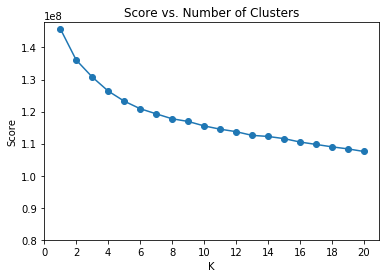

In [81]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(k_list, scores, linestyle='-', marker='o');
plt.xlabel('K');
plt.xticks(np.arange(0, 21, step=2)) # code line based on matplotlib.pyplot.xticks documentation [R4]
plt.ylabel('Score');
plt.yticks(np.arange(0.8e8, 1.5e8, step=0.1e8)) # code line based on matplotlib.pyplot.xticks documentation [R4]
plt.title('Score vs. Number of Clusters');

In [82]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# initialize KMEANS with 19 clusters
k_means = KMeans(n_clusters=19)
# fitting data
model_19 = k_means.fit(azdias_pca)
# use model model_19 for prediction
azdias_cluster = model_19.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

I calculated the score for k values from 1 up to 20 and plotted the results. <br>
Looking at the plot, it looks like that the elbow is located at k=19. <br> 
Therefore, I will use **k=19** for further investigations.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [83]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.head(3)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0


In [84]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

In [85]:
## cleaning customer data
# create copy of original dataset
customers_clean = customers.copy()
# clean data using the already defined function clean_data with NO missing values (fourth argument = 10) and use the columns_outlierlist from the azdias dataset
customers_clean, feat_info_clean, columns_outlier_customers = clean_data(customers_clean, feat_info, 0.20, 10, columns_outlier_azdias)
# print message "cleaning done"
print('Cleaning done for data frames "customers" and "feat_info"')

Cleaning done for data frames "customers" and "feat_info"


In [86]:
customers_clean.shape

(191652, 192)

In [87]:
# use Imputer to fill NaN
fill_nan = Imputer(strategy='most_frequent')
customers_clean = pd.DataFrame(fill_nan.fit_transform(customers_clean), columns=list(customers_clean))

In [88]:
print('Number of missing values in data frame azdias: {}'.format(customers_clean.isnull().sum().sum()))

Number of missing values in data frame azdias: 0


In [89]:
# check if the new data frame customers_clean has more columns than the old data frame azdias_clean
# if so, which one?
customers_clean.columns.difference(azdias_clean.columns)

Index([], dtype='object')

In [90]:
# check if the old data frame azdias_clean has more columns than the new data frame customers_clean
# if so, which one?
azdias_clean.columns.difference(customers_clean.columns)

Index(['GEBAEUDETYP_5.0'], dtype='object')

In [91]:
# get position of column "GEBAEUDETYP_5.0" at the old data frame
col_position = azdias_clean_scaled.columns.get_loc("GEBAEUDETYP_5.0")
# add column "GEBAEUDETYP_5.0" to the new data frame customers_clean and set all values to 0
customers_clean.insert(col_position, 'GEBAEUDETYP_5.0', 0)

In [92]:
# check if all columns are the same at the same position
customers_clean.columns == azdias_clean_scaled.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [100]:
# Use scaler
customers_clean_scaled = scaler.transform(customers_clean)
# create data frame
customers_clean_scaled = pd.DataFrame(customers_clean_scaled, columns=list(customers_clean))
customers_clean_scaled.head(1)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_MA,PRAEGENDE_JUGENDJAHRE_DEC,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,1.23164,-1.045218,1.457527,-1.243244,1.209329,-1.329319,-0.58798,-0.794475,2.021423,-1.70899,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,2.021423,-1.657705,-1.653917,0.221098


In [101]:
# perform PCA transformation
customers_pca = pca_95.transform(customers_clean_scaled)
customers_pca = pd.DataFrame(customers_pca)
customers_pca.head(1)

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
0,-7.452319,2.511596,2.469877,3.657313,1.126841,-2.061352,1.013955,-1.312777,0.366598,2.941666,...,1.503565,-0.843543,-0.300922,-0.518046,2.018914,-2.101352,-1.186814,-0.099643,0.47502,-0.475011


In [102]:
# use model model_19 for prediction
customers_cluster = model_19.predict(customers_pca)
customers_cluster

array([ 7, 17, 16, ..., 16,  5, 17], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

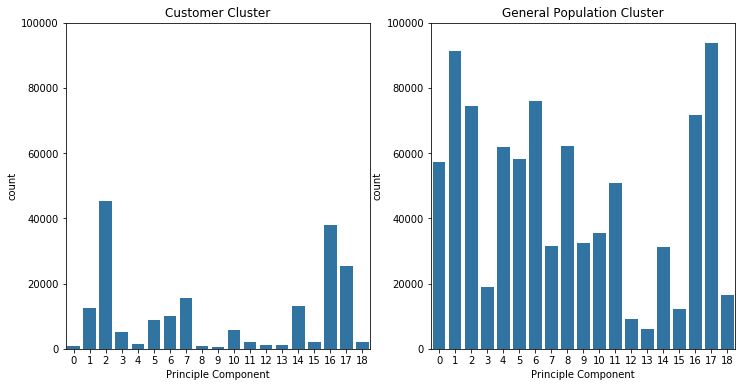

In [103]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# create two subplots to directly compare the customers cluster with the general population cluster
figure, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6));
base_color = sns.color_palette()[0]
sns.countplot(customers_cluster, ax=axs[0], color = base_color);
axs[0].set_title('Customer Cluster');
axs[0].set_xlabel('Principle Component');
axs[0].set(yticks=np.arange(0, 1.2e5, step=0.2e5));
sns.countplot(azdias_cluster, ax=axs[1], color = base_color);
axs[1].set_title('General Population Cluster');
axs[1].set_xlabel('Principle Component');
axs[1].set(yticks=np.arange(0, 1.2e5, step=0.2e5));

In [104]:
# combine both count plot for a easier viewing, after reviewing Pandas documentatin [R5]
df_tmp1 = pd.DataFrame(pd.DataFrame(azdias_cluster)[0].value_counts(sort=False))
df_tmp2 = pd.DataFrame(pd.DataFrame(customers_cluster)[0].value_counts(sort=False))
df_tmp3 = df_tmp1 - df_tmp2.fillna(0)

df_result = pd.concat([df_tmp1, df_tmp2], axis=1)
df_result = df_result.fillna(0)
df_result.columns = ['azdias', 'customers']
df_result['azdias - customers'] = df_result['azdias'] - df_result['customers']
df_result

,azdias,customers,azdias - customers
0,57170,815,56355
1,91380,12399,78981
2,74499,45318,29181
3,18917,5017,13900
4,61970,1438,60532
5,58094,8935,49159
6,76031,10054,65977
7,31643,15457,16186
8,62119,861,61258
9,32373,628,31745


In [105]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?


From the above plot and table one sees that there is no overrepresentation of the the customer data compared to the general population.

In [110]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

centroid_01 = scaler.inverse_transform(pca_95.inverse_transform(model_19.cluster_centers_[1]))
underrepres_cluster = pd.Series(data = centroid_01, index = customers_clean.columns)
underrepres_cluster.sort_values(ascending=False)

MIN_GEBAEUDEJAHR             1992.546327
PRAEGENDE_JUGENDJAHRE_DEC    1965.989553
KBA13_ANZAHL_PKW              574.401774
ANZ_HAUSHALTE_AKTIV            15.144325
WOHNDAUER_2008                  8.105388
ORTSGR_KLS9                     6.787326
SEMIO_VERT                      5.786458
HH_EINKOMMEN_SCORE              5.402109
SEMIO_FAM                       5.290593
SEMIO_SOZ                       5.188557
EWDICHTE                        5.145996
SEMIO_KULT                      5.084403
W_KEIT_KIND_HH                  4.997828
REGIOTYP                        4.877460
SEMIO_LUST                      4.868129
RETOURTYP_BK_S                  4.602723
CAMEO_INTL_2015_WEALTH          4.347217
SEMIO_MAT                       4.265229
FINANZ_VORSORGER                4.257372
SEMIO_ERL                       4.132321
SEMIO_REL                       4.009411
SEMIO_KRIT                      3.762313
RELAT_AB                        3.743724
PLZ8_HHZ                        3.700102
ARBEIT          

### Discussion 3.3: Compare Customer Data to Demographics Data

In my clustering I have no overrepresentation of the customer data compared to the general population which in visible in the plots above. All the principle components are underrepresented in the customer data compared to the general population, except the principle components 12 and 13 which are at a comparable level. <br>
The example cluster 01 has a strong positive correlation with "MIN_GEBAEUDEJAHR", "PRAEGENDE_JUGENDJAHRE_DEC" and "KBA13_ANZAHL_PKW" which indicates the first year that the building was mentioned in the database, the decade of the youth of the users and therefore the age of the person and also the number of cars in the zip code area.


### References: 
[R1] Pandas Replace Documentation: https://pandas.pydata.org/pandas-docs/stable/reference <br>
[R2] Change type of column: https://stackoverflow.com/questions/15891038/change-data-type-of-columns-in-pandas <br>
[R3] Function definition *scree_plot* from helper.py of Udacity ND Course, Section 4.4.14 <br>
[R4] Changing x-ticks: https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.xticks.html <br>
[R5] Concat Data frames in Panda: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html <br>

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.